In [2]:
## Connect colab with google drive
from google.colab import drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
import librosa
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa.display
import numpy as np
import glob
import pandas as pd
import os
import seaborn as sns

In [7]:
path="/content/drive/MyDrive/emotion dataset/TESS Toronto emotional speech set data"

In [8]:
data = list(glob.glob(path+'/**/*.wav'))

In [9]:
labels = list(map(lambda x:os.path.split(os.path.split(x)[0])[1], data))
file_path = pd.Series(data, name='File_Path').astype(str)
labels = pd.Series(labels, name='Labels')
data = pd.concat([file_path, labels], axis=1)
data = data.sample(frac=1).reset_index(drop=True)
data.head()

,File_Path,Labels
0,/content/drive/MyDrive/emotion dataset/TESS To...,OAF_Sad
1,/content/drive/MyDrive/emotion dataset/TESS To...,OAF_Fear
2,/content/drive/MyDrive/emotion dataset/TESS To...,YAF_pleasant_surprised
3,/content/drive/MyDrive/emotion dataset/TESS To...,YAF_neutral
4,/content/drive/MyDrive/emotion dataset/TESS To...,YAF_neutral


In [10]:
data["Labels"] = [i.replace('YAF_','') for i in data["Labels"]]
data["Labels"] = [i.replace('OAF_','') for i in data["Labels"]]
data["Labels"] = [i.replace('pleasant_surprised','Pleasant_surprise') for i in data["Labels"]]
data["Labels"] = [i.replace('fear','Fear') for i in data["Labels"]]
data["Labels"] = [i.replace('sad','Sad') for i in data["Labels"]]

In [ ]:
# EDA

In [ ]:
count= dict(data["Labels"].value_counts())


In [ ]:
labels = list(count.keys())
c = list(count.values())

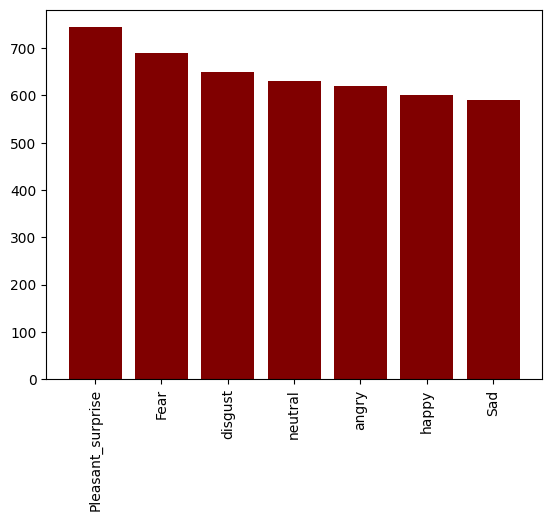

In [ ]:
plt.bar(labels,c,color = "maroon")
plt.xticks(rotation=90)
plt.show()

In [ ]:
for i in range(4):
    x, sr = librosa.load(data.File_Path[i])
    plt.figure(figsize=(14,5))
    plt.title('Labels: '+str(data['Labels'][i]))
    librosa.display.waveshow(x, sr=sr)
    ipd.Audio(data.File_Path[i])

AttributeError: ignored

In [ ]:
for i in range(4):
    m, sampling_rate = librosa.load(data.File_Path[i])
    x = librosa.stft(m)
    xdb = librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(11,4))
    plt.title(data["Labels"][i], size=20)
    librosa.display.specshow(xdb, sr=sampling_rate, x_axis='time', y_axis='hz')
    plt.colorbar()

IndexError: ignored

In [ ]:
def feature_extract(file):
    audio, sample_rate = librosa.load(file)
    mfcc_feature = librosa.feature.mfcc(y=audio,sr = sample_rate, n_mfcc=40)
    mfcc_scaled_feature = np.mean(mfcc_feature.T,axis=0)
    return mfcc_scaled_feature

In [ ]:
features = []
for index, row in data.iterrows():
    file_name = str(row['File_Path'])
    class_label = row["Labels"]
    data_ = feature_extract(file_name)
    features.append([data_, class_label])

In [ ]:
featuresdf = pd.DataFrame(features, columns=['feature','class_label'])
featuresdf.head()

,feature,class_label
0,"[-394.47424, 46.4099, 36.852325, 34.34379, 1.3...",sad
1,"[-408.01715, 59.064392, 2.3322515, 30.44907, -...",disgust
2,"[-316.0639, 61.269257, -4.861632, 8.989775, -1...",fear
3,"[-367.17355, 39.569935, -2.0108578, 16.947832,...",angry
4,"[-451.72186, 73.79866, 19.80299, -10.128079, 0...",Fear


In [ ]:
X = np.array(featuresdf.feature.tolist())
y = np.array(featuresdf.class_label.tolist())

In [ ]:
print(X.shape,y.shape)

(4525, 40) (4525,)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.callbacks import Callback,EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.layers import Conv2D, Activation, Flatten, Dense,GlobalAveragePooling2D, Dropout

In [ ]:
le = LabelEncoder()
y = to_categorical(le.fit_transform(y))

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

In [ ]:
model = Sequential()
model.add(Dense(64, input_dim=40,  activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(46, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(7, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 64)                2624      
                                                                 
 dropout_11 (Dropout)        (None, 64)                0         
                                                                 
 dense_16 (Dense)            (None, 46)                2990      
                                                                 
 dropout_12 (Dropout)        (None, 46)                0         
                                                                 
 dense_17 (Dense)            (None, 32)                1504      
                                                                 
 dropout_13 (Dropout)        (None, 32)                0         
                                                                 
 dense_18 (Dense)            (None, 9)                

In [ ]:
h = model.fit(x_train, y_train, validation_data=(x_test, y_test),epochs=30)

Epoch 1/30
114/114 [==============================] - 0s 4ms/step - loss: 0.2153 - accuracy: 0.9334 - val_loss: 0.0434 - val_accuracy: 0.9934
Epoch 2/30
114/114 [==============================] - 0s 3ms/step - loss: 0.1862 - accuracy: 0.9409 - val_loss: 0.0355 - val_accuracy: 0.9934
Epoch 3/30
114/114 [==============================] - 0s 3ms/step - loss: 0.1822 - accuracy: 0.9409 - val_loss: 0.0355 - val_accuracy: 0.9923
Epoch 4/30
114/114 [==============================] - 0s 3ms/step - loss: 0.1826 - accuracy: 0.9390 - val_loss: 0.0467 - val_accuracy: 0.9878
Epoch 5/30
114/114 [==============================] - 0s 3ms/step - loss: 0.1626 - accuracy: 0.9467 - val_loss: 0.0321 - val_accuracy: 0.9923
Epoch 6/30
114/114 [==============================] - 0s 3ms/step - loss: 0.1488 - accuracy: 0.9550 - val_loss: 0.0212 - val_accuracy: 0.9956
Epoch 7/30
114/114 [==============================] - 0s 3ms/step - loss: 0.1315 - accuracy: 0.9630 - val_loss: 0.0238 - val_accuracy: 0.9923
Epoch 

In [ ]:
r = pd.DataFrame(h.history)
r['Epochs'] = h.epoch
r.tail()

,loss,accuracy,val_loss,val_accuracy,Epochs
25,0.049146,0.984254,0.010970,0.99779,25
26,0.050642,0.984530,0.010821,0.99779,26
27,0.062117,0.982044,0.014961,0.99558,27
28,0.055915,0.984530,0.014756,0.99558,28
29,0.054266,0.984254,0.027680,0.99116,29


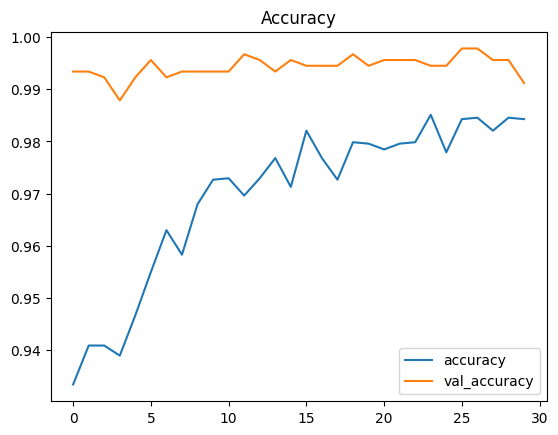

In [ ]:
pd.DataFrame(h.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

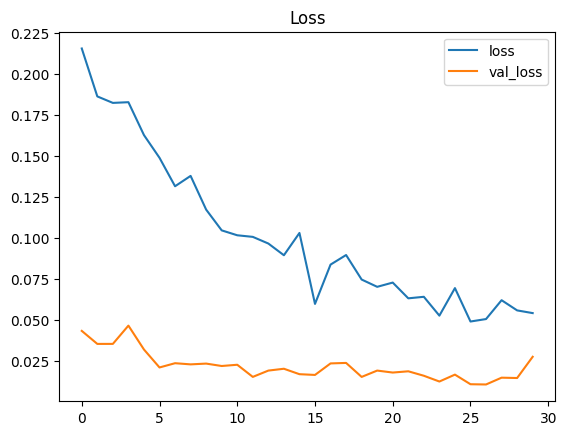

In [ ]:
pd.DataFrame(h.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [ ]:
def prediction_(path_sound):
    data_sound = feature_extract(path_sound)
    X = np.array(data_sound)
    X = X.reshape(1,40)
    pred_ = model.predict(X)
    pred_ = np.argmax(pred_,axis=1)
    pred_class = le.inverse_transform(pred_)
    print("The predicted class is:\033[01m ", pred_class[0],'\033[0m \n')

In [ ]:
path_sound = '/content/drive/MyDrive/emotion dataset/TESS Toronto emotional speech set data/OAF_disgust/OAF_back_disgust.wav'
prediction_(path_sound)
ipd.Audio(path_sound)

1/1 [==============================] - 0s 121ms/step
The predicted class is:  disgust  



In [ ]:
path_sound="/content/drive/MyDrive/emotion dataset/TESS Toronto emotional speech set data/OAF_Sad/OAF_back_sad(1).wav"
prediction_(path_sound)
ipd.Audio(path_sound)

1/1 [==============================] - 0s 35ms/step
The predicted class is:  Sad  



In [ ]:
# PREDICTION LABELS
predictions = model.predict(x_test, batch_size=32)
predictions=predictions.argmax(axis=1)
predictions
predictions = predictions.astype(int).flatten()
predictions = (le.inverse_transform((predictions)))
predictions = pd.DataFrame({'Predicted Values': predictions})

# ACTUAL LABELS
actual=y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (le.inverse_transform((actual)))
actual = pd.DataFrame({'Actual Values': actual})

# COMBINE PREDICTION AND ACTUAL LABELS
finaldf = actual.join(predictions)
finaldf.head()

29/29 [==============================] - 0s 3ms/step


,Actual Values,Predicted Values
0,fear,fear
1,Pleasant_surprise,Pleasant_surprise
2,fear,fear
3,angry,angry
4,Pleasant_surprise,Pleasant_surprise


In [ ]:
import seaborn as sns

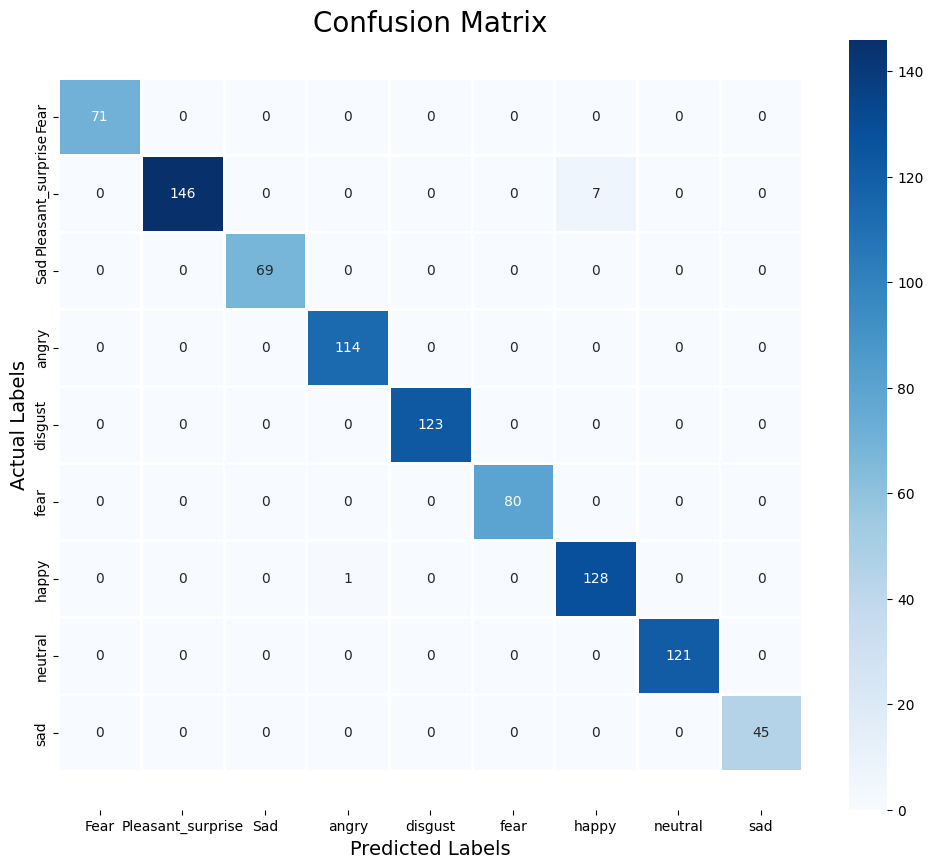

In [ ]:
cm = confusion_matrix(actual, predictions)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in le.classes_] , columns = [i for i in le.classes_])
ax = sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.savefig('Augmented_Model_Confusion_Matrix.png')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(actual, predictions, target_names = ['angry','Sad','fear','disgust','Fear','happy','neutral','sad','Pleasant_surprise']))


                   precision    recall  f1-score   support

            angry       1.00      1.00      1.00        71
              Sad       1.00      0.95      0.98       153
             fear       1.00      1.00      1.00        69
          disgust       0.99      1.00      1.00       114
             Fear       1.00      1.00      1.00       123
            happy       1.00      1.00      1.00        80
          neutral       0.95      0.99      0.97       129
              sad       1.00      1.00      1.00       121
Pleasant_surprise       1.00      1.00      1.00        45

         accuracy                           0.99       905
        macro avg       0.99      0.99      0.99       905
     weighted avg       0.99      0.99      0.99       905

